In [30]:
import pandas as pd
import numpy as np
import json
import re

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.cluster import KMeans, MeanShift
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

from sklearn.utils import shuffle

In [2]:
# Silence warnings
import warnings
warnings.filterwarnings("ignore")
pd.options.mode.chained_assignment = None

In [3]:
df = pd.read_json('json/corpus.json').reset_index().rename(
    columns={'duration_ms':'duration'}).dropna(subset = ['root'])[['root', 'loudness', 'duration', 'track_id',
                                                'time_signature', 'tempo', 'mode', 'energy', 'valence']]

In [4]:
df_genres = pd.read_csv('data/genre_categories_grouped.csv').drop(columns='Unnamed: 0')[['main_genre', 'track_id']]

In [5]:
list_genres = pd.read_json(
    'json/music_genres_classification.json').reset_index().drop(
    columns = 'index')['genre'].values

In [6]:
print(list_genres)

['blues' 'caribbean and caribbean-influenced' 'r&b and soul' 'rock'
 'country' 'easy listening' 'electronic music' 'folk' 'hip hop' 'jazz'
 'latin' 'pop']


In [7]:
df = pd.merge(df, df_genres, on = 'track_id', how = 'inner').drop(columns = 'track_id')

In [8]:
df.head(5)

,root,loudness,duration,time_signature,tempo,mode,energy,valence,main_genre
0,0.0,-11.573,153933.0,4.0,154.999,1.0,0.332,0.795,"{'blues', 'country', 'rock', 'pop', 'other'}"
1,1.0,-9.522,140867.0,4.0,137.396,1.0,0.638,0.837,"{'caribbean and caribbean-influenced', 'latin'..."
2,1.0,-9.522,140867.0,4.0,137.396,1.0,0.638,0.837,"{'caribbean and caribbean-influenced', 'latin'..."
3,1.0,-9.522,140867.0,4.0,137.396,1.0,0.638,0.837,"{'caribbean and caribbean-influenced', 'latin'..."
4,1.0,-9.522,140867.0,4.0,137.396,1.0,0.638,0.837,"{'caribbean and caribbean-influenced', 'latin'..."


In [9]:
dico = {}
for genre in list_genres:
    dico[genre] = []

for ind, item in df['main_genre'].iteritems():
    for genre in list_genres:
        if len(re.findall(genre, item)) > 0:
            dico[genre].append(ind)

In [10]:
dfs = []

for i in range(len(list_genres)):
    genre = list_genres[i]
    ids = dico[genre]
    df_genre = df.iloc[ids]
    df_genre['genre'] = i
    dfs.append(df_genre)

In [11]:
df_tot = dfs[0]

for dataframe in dfs[1:]:
    df_tot = pd.concat([df_tot, dataframe])
    
df_tot = df_tot.reset_index().drop(columns = ['main_genre', 'index'])

In [12]:
df_tot.head(1)

,root,loudness,duration,time_signature,tempo,mode,energy,valence,genre
0,0.0,-11.573,153933.0,4.0,154.999,1.0,0.332,0.795,0


## Try to retrieve genres with clustering/decomposition algorithms
### Fisher LDA

In [13]:
roots = pd.get_dummies(df_tot['root']).rename(columns = {0.0: 'C', 1.0: 'C#', 2.0: 'D', 3.0: 'D#', 4.0: 'E',
                                                        5.0: 'F', 6.0: 'F#', 7.0: 'G', 8.0: 'G#', 9.0: 'A',
                                                        10.0: 'A#', 11.0: 'B'})

In [14]:
for root in roots.columns.tolist():
    df_tot[root] = roots[root]
    
df_tot = df_tot.drop(columns = 'root')

In [15]:
X = df_tot.drop(columns = 'genre')
y = df_tot['genre']

X, y = shuffle(X, y, random_state=23)

In [76]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42, shuffle = True)
lda = LinearDiscriminantAnalysis()
lda.fit(X_train, y_train)
lda.score(X_test, y_test)

0.3075550267697799

In [21]:
lda.priors_

array([0.05825738, 0.00286825, 0.14825674, 0.29778826, 0.10007011,
       0.02575053, 0.02626044, 0.01478743, 0.03958187, 0.04697559,
       0.2394034 ])

In [16]:
lda = LinearDiscriminantAnalysis()
lda.fit(X, y)

LinearDiscriminantAnalysis(n_components=None, priors=None, shrinkage=None,
              solver='svd', store_covariance=False, tol=0.0001)

In [17]:
df_tot.columns

Index(['loudness', 'duration', 'time_signature', 'tempo', 'mode', 'energy',
       'valence', 'genre', 'C', 'C#', 'D', 'D#', 'E', 'F', 'F#', 'G', 'G#',
       'A', 'A#', 'B'],
      dtype='object')

In [18]:
print(list_genres)

['blues' 'caribbean and caribbean-influenced' 'r&b and soul' 'rock'
 'country' 'easy listening' 'electronic music' 'folk' 'hip hop' 'jazz'
 'latin' 'pop']


### Mean Shift

In [ ]:
msc = MeanShift(bandwidth=2).fit(X)

In [25]:
clusters = pd.Series(msc.labels_).value_counts()

In [26]:
print(len(clusters), len(X))

11136 22413


In [29]:
clusters[:10]

0    20
1    18
4    16
2    16
3    16
8    12
5    12
7    12
9    12
6    12
dtype: int64

In [31]:
serie = pd.Series(msc.labels_)
ids = serie[serie == 0]

In [34]:
reference = shuffle(df_tot.index, random_state=23)

In [39]:
ref = pd.Series(reference)

### PCA

In [77]:
len(X.columns)

19

In [78]:
pca = PCA(n_components=2)
pca.fit(X)

PCA(copy=True, iterated_power='auto', n_components=2, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

In [79]:
X_red = pca.transform(X)
X_red.shape

(22413, 2)

#### MS + PCA

In [80]:
msc = MeanShift(bandwidth=2).fit(X_red)
clusters = pd.Series(msc.labels_).value_counts()
print(len(clusters), len(X_red))

10947 22413


### K-Means

In [18]:
kmeans = KMeans(n_clusters = len(list_genres), random_state = 0).fit(X)

In [19]:
kclusters = pd.Series(kmeans.labels_).value_counts()
kclusters

0     4255
10    3708
2     3243
11    3022
5     2572
6     2488
1     1687
7      873
4      427
9      119
3       15
8        4
dtype: int64

In [30]:
sns.set(rc={'figure.figsize':(35,25)})
sns.set_style("ticks")
sns.set(font_scale=1.5)

In [22]:
len(y)

22413

In [23]:
len(kmeans.labels_)

22413

In [24]:
kmeans_vs_genres = pd.DataFrame([y, kmeans.labels_]).transpose().rename(columns = {'Unnamed 0': 'kmeans cluster'})

In [25]:
clusters_dummies = pd.get_dummies(kmeans_vs_genres['kmeans cluster'])
for cluster in clusters_dummies.columns.tolist():
    kmeans_vs_genres[cluster] = clusters_dummies[cluster]
    
kmeans_vs_genres = kmeans_vs_genres.drop(columns = 'kmeans cluster')

In [26]:
genres_dummies = pd.get_dummies(kmeans_vs_genres['genre']).rename(
    columns = {1.0: 'blues', 2.0: 'caribbean', 3.0: 'r&b and soul', 4.0: 'rock', 5.0: 'country', 
               6.0: 'easy listening', 7.0: 'electronic music', 8.0: 'folk', 9.0: 'hip hop', 10.0: 'jazz', 
               11.0: 'latin', 12.0: 'pop'})

for genre in genres_dummies.columns.tolist():
    kmeans_vs_genres[genre] = genres_dummies[genre]
    
kmeans_vs_genres = kmeans_vs_genres.drop(columns = 'genre')

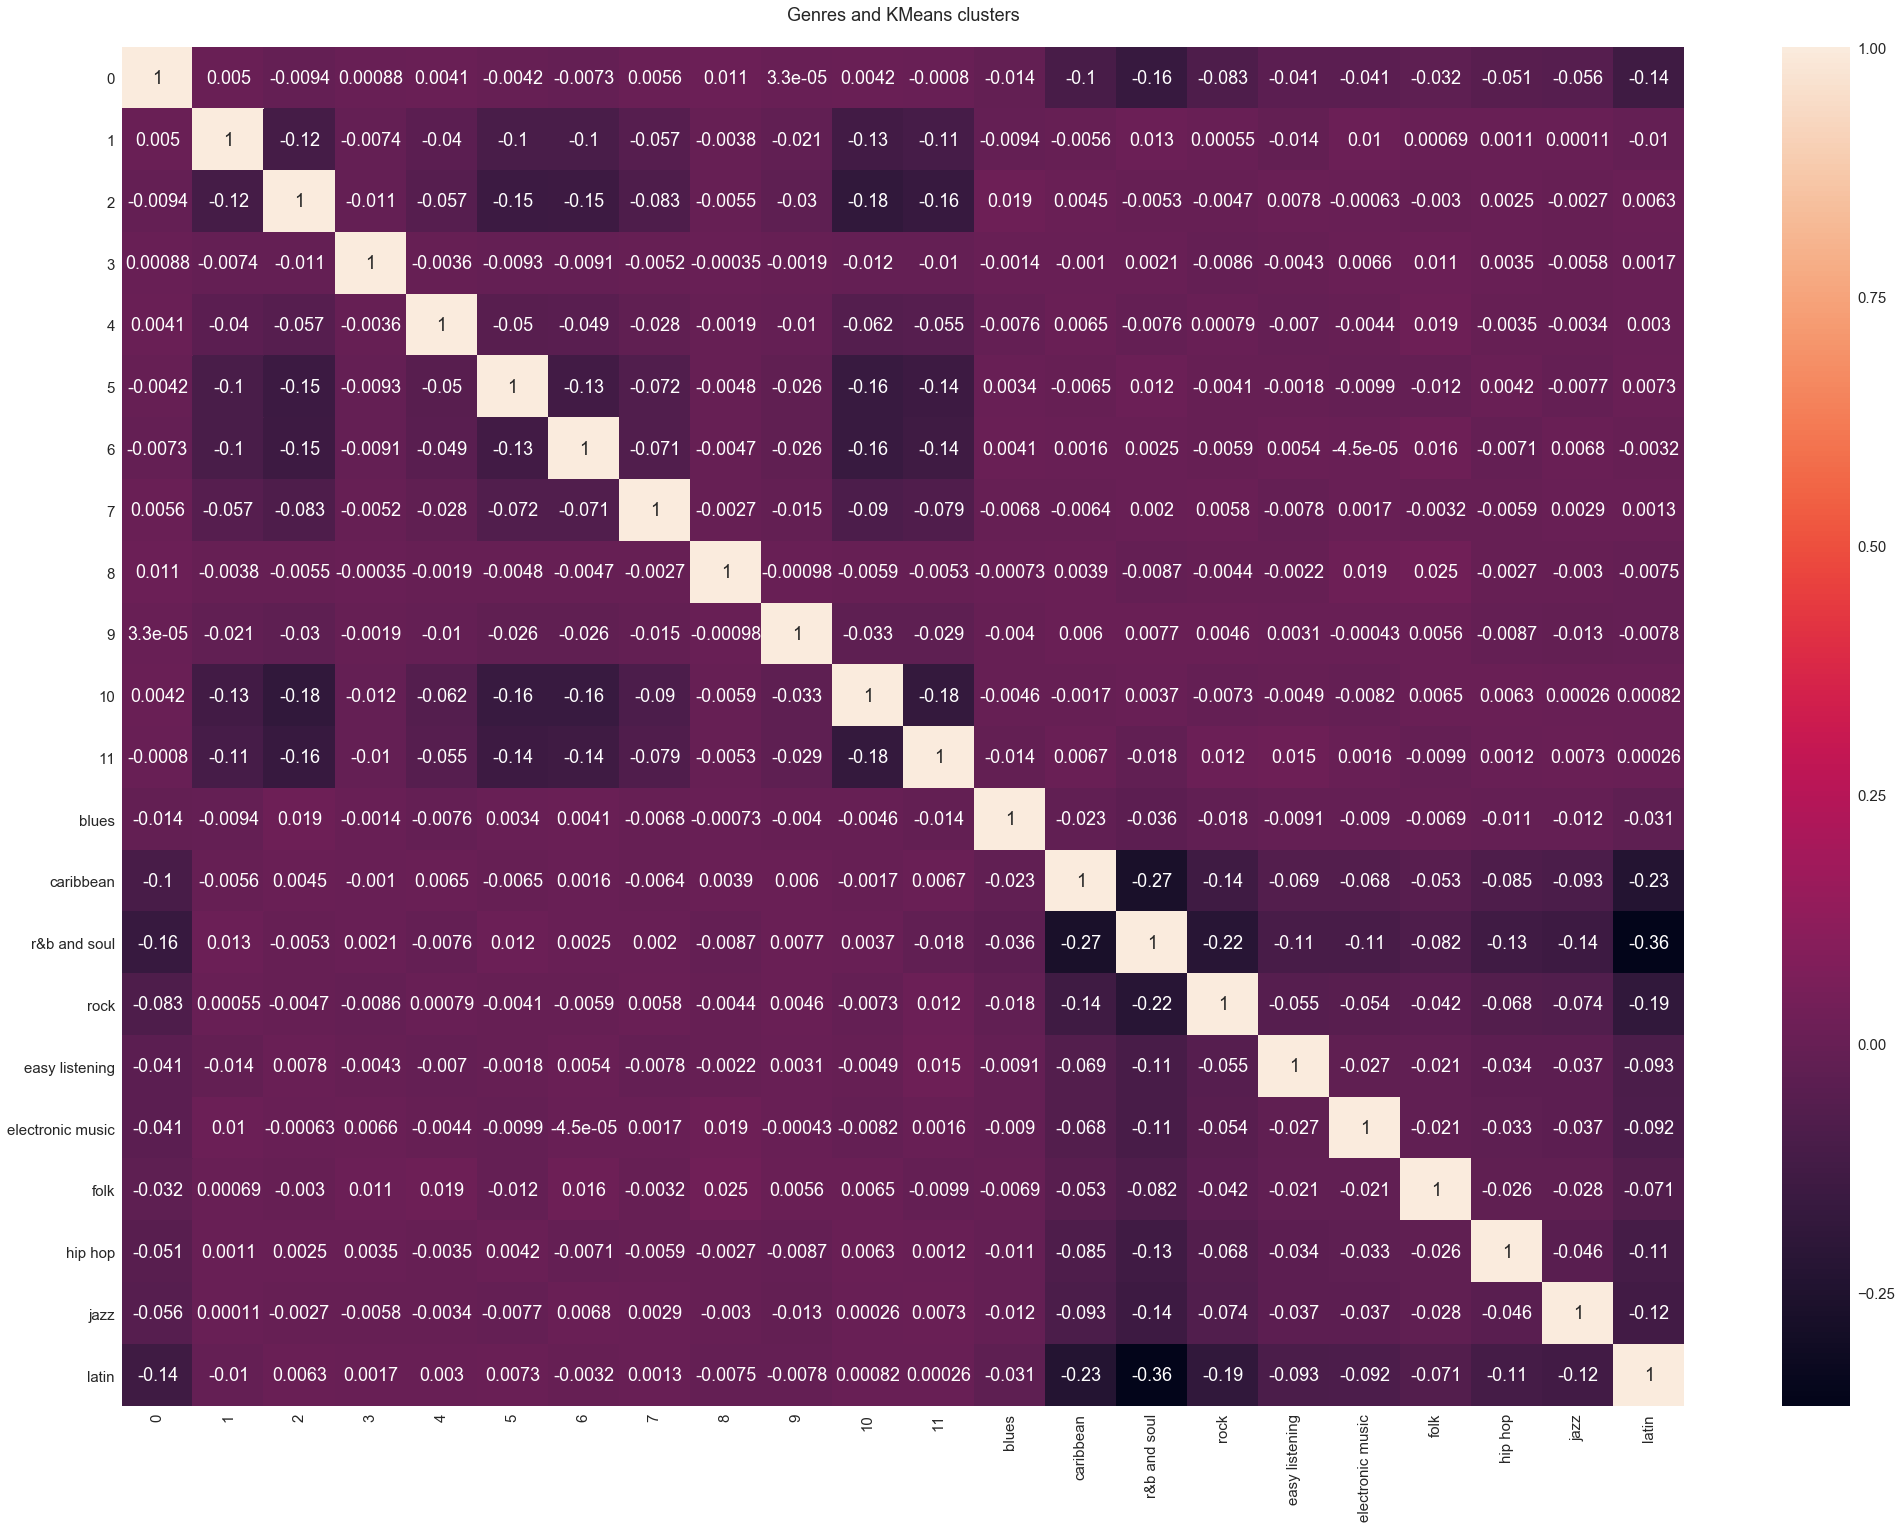

In [31]:
sns.heatmap(kmeans_vs_genres.corr(), annot=True).set_title('Genres and KMeans clusters\n');

## Retrieve the caracteristics of genres

In [16]:
list_genres

array(['blues', 'caribbean and caribbean-influenced', 'r&b and soul',
       'rock', 'country', 'easy listening', 'electronic music', 'folk',
       'hip hop', 'jazz', 'latin', 'pop'], dtype=object)

In [17]:
dummy_genres = []

for ind, item in df['main_genre'].iteritems():
    item_genres = []
    for genre in list_genres:
        if len(re.findall(genre, item)) > 0:
            item_genres.append(1)
        else:
            item_genres.append(0)
    dummy_genres.append(item_genres)

In [18]:
for i in range(len(list_genres)):
    df[list_genres[i]] = np.asarray(dummy_genres).transpose()[i]

In [19]:
df = df.drop(columns = 'main_genre')

In [20]:
df = df.drop(columns = ['caribbean and caribbean-influenced', 'easy listening'])

In [21]:
X = df[['root', 'loudness', 'duration', 'time_signature', 'tempo', 'mode',
       'energy', 'valence']]
y = df[['blues', 'r&b and soul', 'rock', 'country', 'electronic music',
       'folk', 'hip hop', 'jazz', 'latin', 'pop']]

X, y = shuffle(X, y, random_state=23)

In [22]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42, shuffle = True)

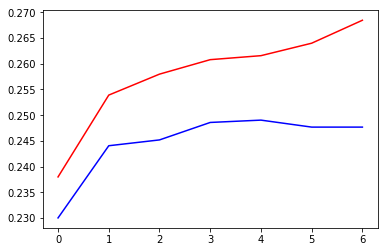

In [46]:
depths = np.arange(1, 8, 1)

train_score, test_score = [], []

for depth in depths:
    clf = RandomForestClassifier(n_estimators = 100, max_depth = depth, random_state = 12)
    clf.fit(X_train, y_train)
    train_score.append(clf.score(X_train, y_train))
    test_score.append(clf.score(X_test, y_test))

plt.plot(train_score, color = 'r')
plt.plot(test_score, color = 'b')

In [23]:
list_genres = ['blues', 'r&b and soul', 'rock', 'country', 'electronic music', 'folk',
               'hip hop', 'jazz', 'latin', 'pop']

In [50]:
scores = []
for genre in list_genres:
    X = df[['root', 'loudness', 'duration', 'time_signature', 'tempo', 'mode',
       'energy', 'valence']]
    y = df[genre]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42, shuffle = True)
    
    depths = np.arange(1, 11, 1)
    train_score, test_score = [], []

    for depth in depths:
        clf = RandomForestClassifier(n_estimators = 100, max_depth = depth, random_state = 12)
        clf.fit(X_train, y_train)
        train_score.append(clf.score(X_train, y_train))
        test_score.append(clf.score(X_test, y_test))
    scores.append(np.max(test_score))

In [52]:
# Chance
for genre in list_genres:
    print(1-(df[genre].sum()/len(df)))

0.9106948968512486
0.7756514657980456
0.5487920738327905
0.8494163952225842
0.9591476655808904
0.9602334419109664
0.9761129207383279
0.9389929424538546
0.927999457111835
0.6365363735070575


In [51]:
scores

[0.914179104477612,
 0.7825644504748982,
 0.6197421981004071,
 0.8405698778833107,
 0.9555630936227951,
 0.9606512890094979,
 0.9752374491180461,
 0.9379240162822252,
 0.9216417910447762,
 0.6431478968792401]

In [31]:
for dim in [8,7,6,5,4,3,2,1]:
    scores = []
    chance = []
    for genre in list_genres:
        X = df[['root', 'loudness', 'duration', 'time_signature', 'tempo', 'mode',
           'energy', 'valence']]
        y = df[genre]
        
        pca = PCA(n_components=dim)
        X = pca.fit_transform(X)
        
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42, shuffle = True)
    
        depths = np.arange(1, 11, 1)
        train_score, test_score = [], []

        for depth in depths:
            clf = RandomForestClassifier(n_estimators = 100, max_depth = depth, random_state = 12)
            clf.fit(X_train, y_train)
            train_score.append(clf.score(X_train, y_train))
            test_score.append(clf.score(X_test, y_test))
        scores.append(np.max(test_score))
        chance.append(df[genre].sum()/len(df))
    
    total = 0.
    for i in range(len(list_genres)):
        total += (scores[i] - (1-chance[i]))*chance[i]*100
    
    print('Total score:', total, '% better than chance, with dimensionality', dim)

Total score: 3.460809297373061 % better than chance, with dimensionality 8
Total score: 2.689516313815872 % better than chance, with dimensionality 7
Total score: 2.90638613998853 % better than chance, with dimensionality 6
Total score: 2.3445990950533058 % better than chance, with dimensionality 5
Total score: 2.010938334597369 % better than chance, with dimensionality 4
Total score: 1.472753021158641 % better than chance, with dimensionality 3
Total score: 1.1422689299180706 % better than chance, with dimensionality 2
Total score: 0.26232695339264267 % better than chance, with dimensionality 1


In [ ]:
for dim in [3,2,1]:
    scores = []
    chance = []
    for genre in list_genres:
        X = df[['root', 'loudness', 'duration', 'time_signature', 'tempo', 'mode',
           'energy', 'valence']]
        y = df[genre]
        
        tsne = TSNE(n_components=dim)
        X = tsne.fit_transform(X)
        
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42, shuffle = True)
    
        depths = np.arange(1, 11, 1)
        train_score, test_score = [], []

        for depth in depths:
            clf = RandomForestClassifier(n_estimators = 100, max_depth = depth, random_state = 12)
            clf.fit(X_train, y_train)
            train_score.append(clf.score(X_train, y_train))
            test_score.append(clf.score(X_test, y_test))
        scores.append(np.max(test_score))
        chance.append(df[genre].sum()/len(df))
    
    total = 0.
    for i in range(len(list_genres)):
        total += (scores[i] - (1-chance[i]))*chance[i]*100
    
    print('Total score:', total, '% better than chance, with dimensionality', dim)